Please follow the official PyTorch tutorial for preparing a simple Speech Recognition Pipeline. Then proceed to select a short video clip (about 10 seconds) from the internet (for instance, a SFW meme) and try to generate a full transcription.

The process of speech recognition looks like the following.

Extract the acoustic features from audio waveform

Estimate the class of the acoustic features frame-by-frame

Generate hypothesis from the sequence of the class probabilities

In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.5.0+cu121
2.5.0+cu121
cpu


In [ ]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset(
    "tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
)

100%|██████████| 106k/106k [00:00<00:00, 26.2MB/s]


In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:01<00:00, 205MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [ ]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

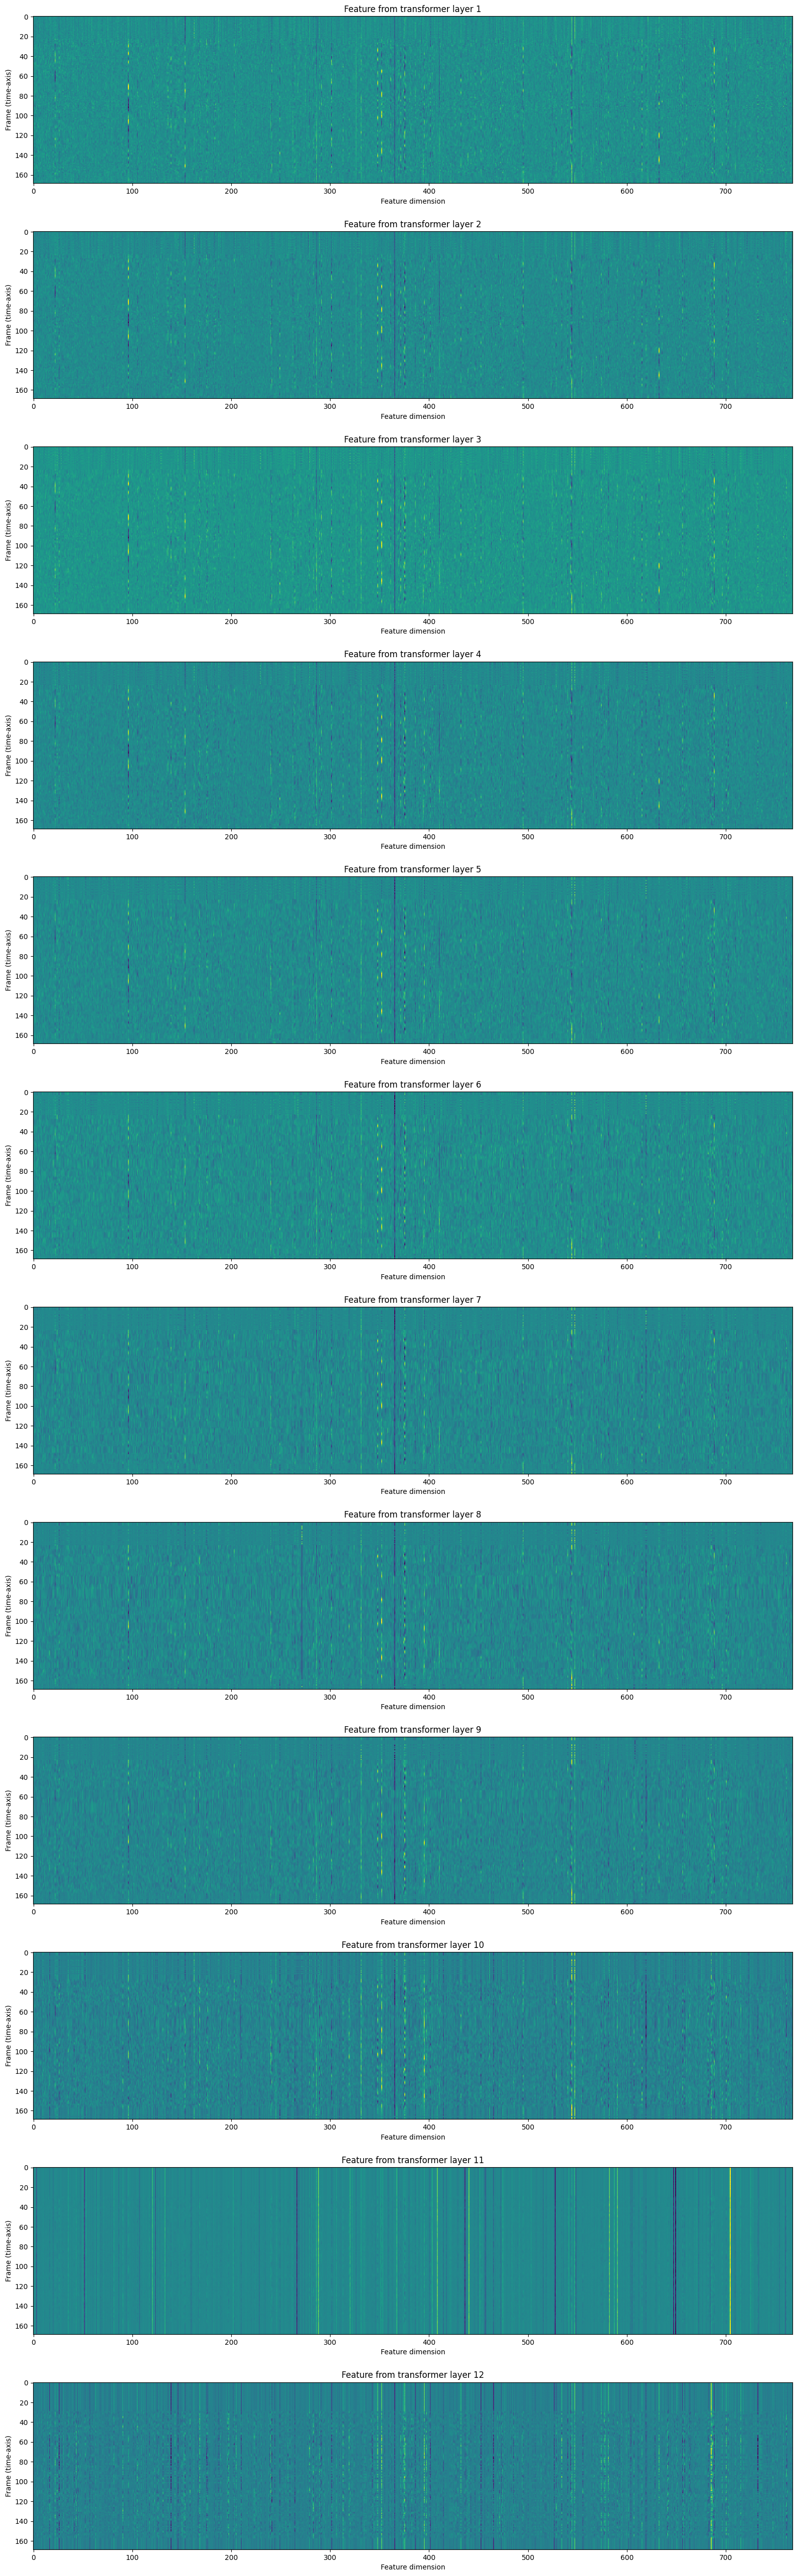

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


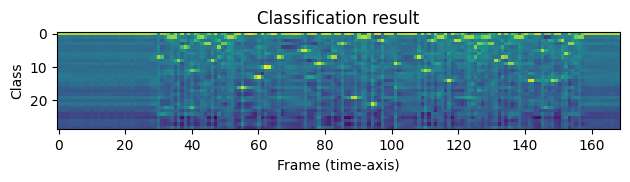

In [ ]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [ ]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


In [ ]:
model = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
emission = model(waveforms, ...)